# Unsupervised anomaly detection with Temporian and scikit-learn

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/temporian/blob/last-release/docs/src/tutorials/anomaly_detection_unsupervised.ipynb)

This tutorial demonstrates how to use Temporian and scikit-learn to detect anomalies in a multivariate time series dataset.

Anomaly detection in time series, time sequences and other temporal formats is critical in a variety of domains. For instance, it is used in manufacturing to detect equipment failure and production lines, in computer systems and by financial institutions to detect fraudulent activities, and in energy management to detect outages.

We will use the Server Machine Dataset (SMD) dataset, published as part of the [OmniAnomaly](https://github.com/NetManAIOps/OmniAnomaly/) paper, which is available in CSV files in that same repository.

This dataset contains aggregated resource usage metrics (e.g., CPU and RAM utilization, network traffic) from 28 computers in 3 data centers over a period of 5 weeks. The timestamps and feature names have been anonymized and normalized. Therefore, calendar feature engineering or the use of expert knowledge is not possible.

The dataset will be loaded, feature engineered and converted into a tabular dataset using Temporian. Then, we will use an isolation forest model on this tabular data to detect anomalies. Finally, we will evaluate the quality of our detection on the ground truth anomalies, available as part of the testing dataset.

Check out the [Supervised anomaly detection](https://temporian.readthedocs.io/en/stable/tutorials/anomaly_detection_supervised/) tutorial for a version of this notebook that trains a supervised model using the ground truth labels, which is less common in an anomaly detection setting, but can yield better performance if those are available.

## Installation and imports

In [1]:
%pip install temporian -q


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

import temporian as tp

## Downloading the dataset

The dataset is comprised of 3 groups of 8, 9, and 11 machines respectively, with names `"machine-1-1"`, ..., `"machine-3-11"`.

Let's create the list of names, and then download each machine's data and labels to a `tmp/temporian_server_machine_dataset/` folder.

For the sake of time we'll only be using 3 machines' data, but we encourage you to try it out in the complete dataset by swapping the commented line with the following one in the cell below.

In [3]:
# Create list of machine names

# machines_per_group = [8, 9, 11]
machines_per_group = [2, 1, 0]

machines = [f"machine-{group}-{id}" for group, machine in zip(range(1, 4), machines_per_group) for id in range(1, machine + 1)]

machines

['machine-1-1', 'machine-1-2', 'machine-2-1']

In [4]:
data_dir = Path("tmp/temporian_server_machine_dataset")

data_dir.mkdir(parents=True, exist_ok=True)

DATA = "data.csv"
LABELS = "labels.csv"

# Download the data and labels for each machine to its own folder
for machine in machines:
    print(f"Downloading data and labels for {machine}")
    
    dir = data_dir / machine
    dir.mkdir(exist_ok=True)
    
    data_path = dir / DATA
    if not data_path.exists():
        os.system(f"wget -q -O {data_path} https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/test/{machine}.txt")

    labels_path = dir / LABELS
    if not labels_path.exists():
        os.system(f"wget -q -O {labels_path} https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/test_label/{machine}.txt")

## Loading the data

We'll use pandas to load the data and perform some basic manipulation of it before transforming it into a Temporian `EventSet`.

Note that in the code below, we'll be using the loaded data's pandas index (which is a sequential one) as the `"timestamp"` column for each DataFrame. This will effectively render a time series, since each new event will be one unit of time ahead of the previous one, but it means that the timestamp column has no actual semantic meaning.

We'll use the `"machine"` column as the EventSet's index, which means that Temporian will treat the events corresponding to each machine as an independent time series when computing features off of it. This is clear when displaying the `EventSet`, which renders one table for each of our indexes' values.

In [5]:
evsets = []

for machine in machines:
    dir = data_dir / machine

    # Read the data and labels
    df = pd.read_csv(dir / DATA, header=None).add_prefix("f")
    labels = pd.read_csv(dir/ LABELS, header=None)
    df = df.assign(label=labels)

    # Assign the machine as a feature
    df["machine"] = machine
    
    # Use index as timestamps column
    df = df.reset_index(drop=False, names="timestamp")

    evset = tp.from_pandas(df)

    evsets.append(evset)

# Join each machine's EventSet together
evset = tp.combine(*evsets)

# Set the "machine" feature as the EventSet's index
evset = evset.set_index("machine")

# Cast features to smaller dtypes to preserve memory
evset = evset.cast(tp.float32).cast({"label": tp.int32})

evset
tp.to_csv(evset, "data.csv")

Awesome! Seems like each machine has more than 20.000 events and 39 features (counting the "label" one).

As stated previously, all metrics seem to be anonymized and normalized to `[0, 1]`, so we won't need to take care of that ourselves.

## Data visualization

Let's take a look at some of the first machine's features.

The number of plots (39) is larger than "options.max_num_plots=20". Only the first plots will be printed.


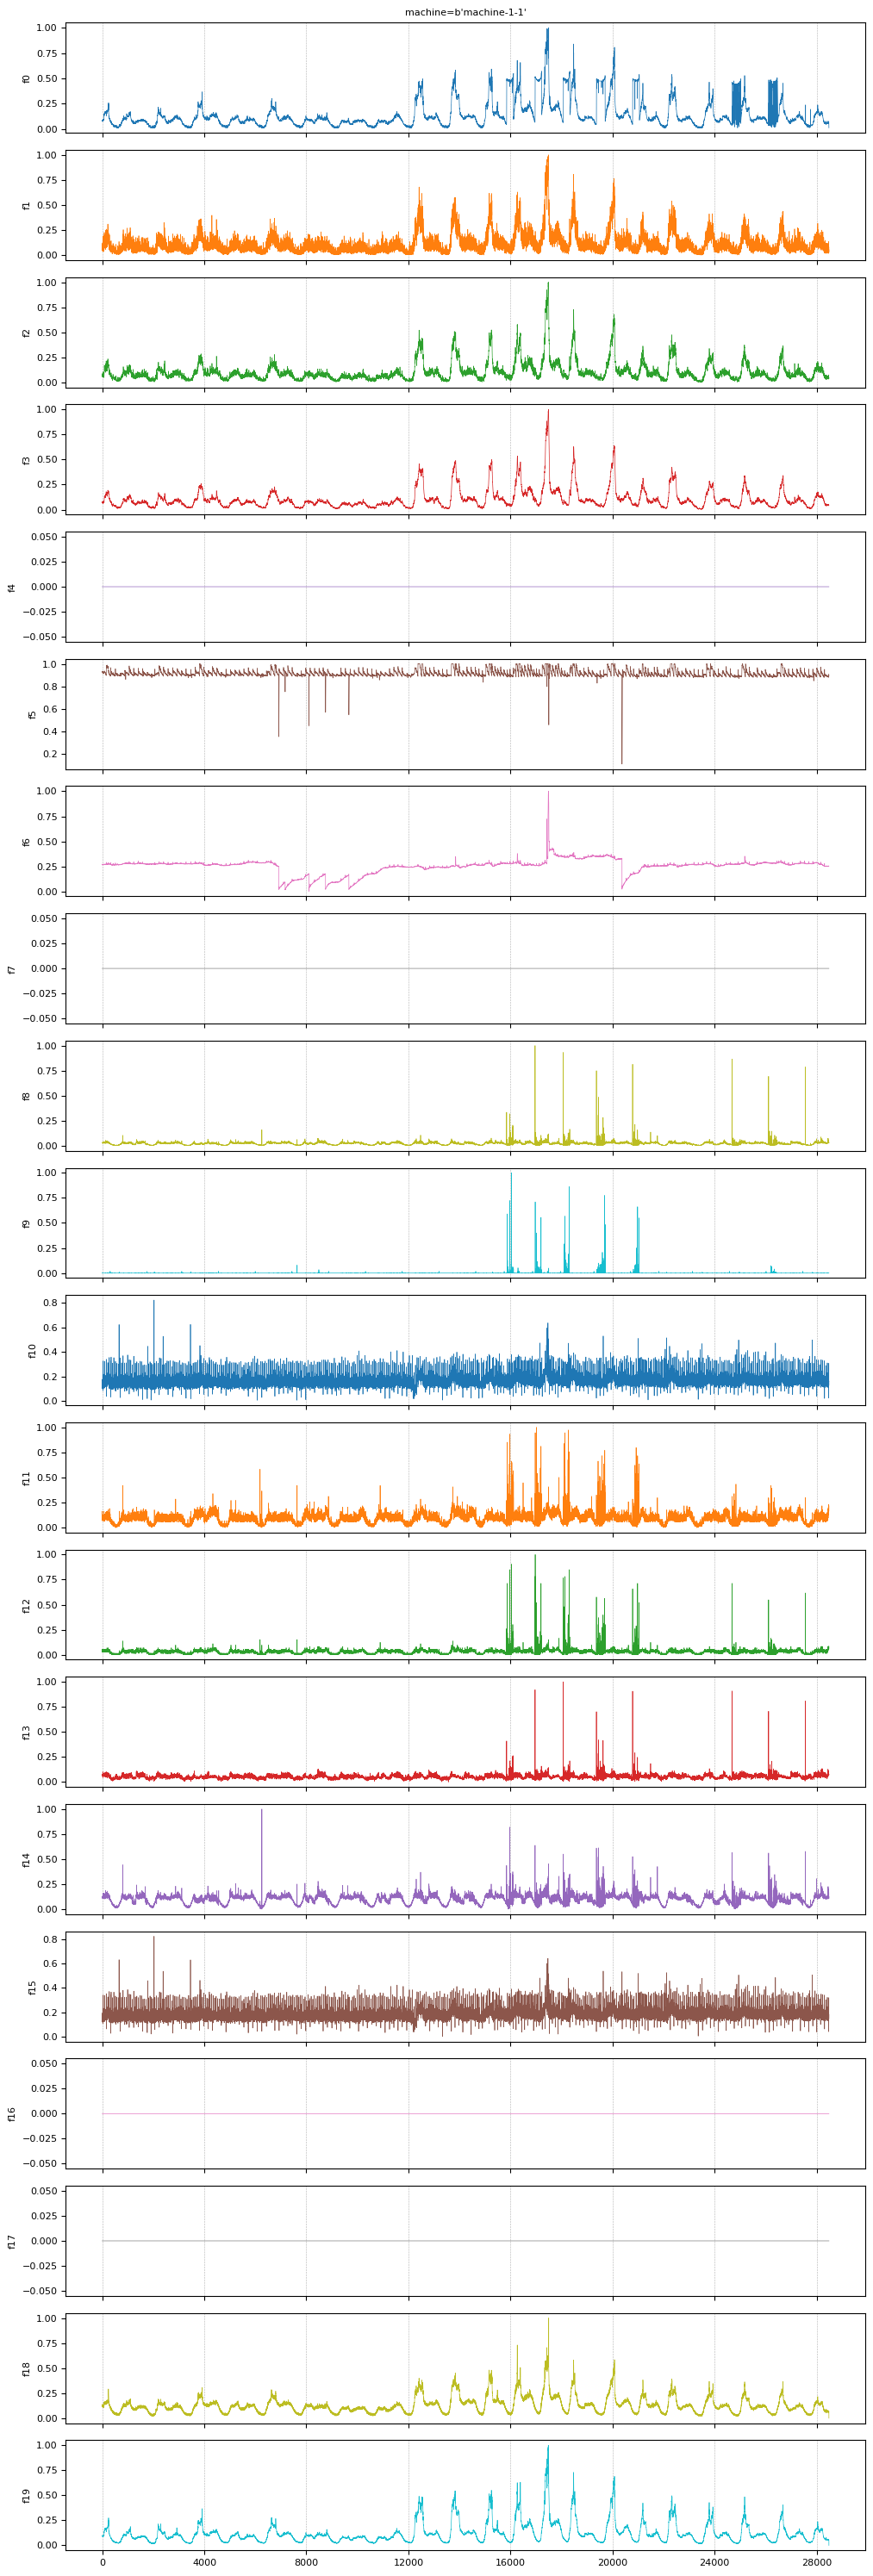

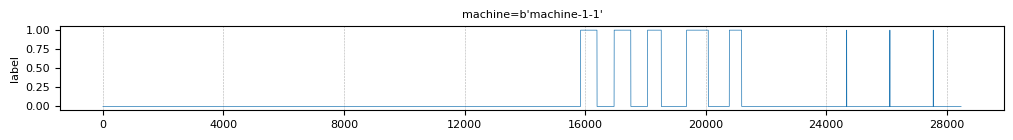

In [6]:
evset.plot(indexes="machine-1-1")
evset[["label"]].plot(indexes="machine-1-1")

Great! A lot to unpack here:
- It seems to be easy to understand when an anomaly occurs (label takes value of 1) by looking at the other plots. Features 11 to 14, for example, seem to be very correlated to the label.
- The data seems to have some periodicity to it.
- Some features seem empty, and we could evaluate dropping them if needed.

## Data preparation

To prepare our data to train a model on it, let's start off by separating the features from the labels.

In [7]:
feature_names = evset.schema.feature_names()
feature_names.remove("label")

raw_features = evset[feature_names]
labels = evset[["label"]]

print("Raw features:", raw_features.schema)
print("Labels:", labels.schema)

Raw features: features: [('f0', float32), ('f1', float32), ('f2', float32), ('f3', float32), ('f4', float32), ('f5', float32), ('f6', float32), ('f7', float32), ('f8', float32), ('f9', float32), ('f10', float32), ('f11', float32), ('f12', float32), ('f13', float32), ('f14', float32), ('f15', float32), ('f16', float32), ('f17', float32), ('f18', float32), ('f19', float32), ('f20', float32), ('f21', float32), ('f22', float32), ('f23', float32), ('f24', float32), ('f25', float32), ('f26', float32), ('f27', float32), ('f28', float32), ('f29', float32), ('f30', float32), ('f31', float32), ('f32', float32), ('f33', float32), ('f34', float32), ('f35', float32), ('f36', float32), ('f37', float32)]
indexes: [('machine', str_)]
is_unix_timestamp: False

Labels: features: [('label', int32)]
indexes: [('machine', str_)]
is_unix_timestamp: False



Next, we'll need to split our dataset into train and testing sets, which we'll use an 80/20 split for.

Note that the train labels will only be used for evaluation purposes.

We'll be creating reusable functions for each step, since we'll do some iteration over the `feature engineering -> training -> evaluation` cycle.

In [8]:
DROP_COLS = ["machine", "timestamp"]

def split_event_set(evset: tp.EventSet, test_frac: float = 0.2):
    # Compute the timestamp that corresponds to test_frac of the data, and use it to split the data
    # Note that not all of each machine's time series are of the same length, so the ones with more will have more test examples
    train_cutoff = int(len(evset.get_arbitrary_index_data()) * (1 - test_frac))
    print("Last train timestamp:", train_cutoff)
    
    # Compute masks and split data based on cutoff
    timestamp = evset.timestamps()
    train_mask = timestamp <= train_cutoff
    test_mask = ~train_mask

    # Split EventSet
    train_evset = evset.filter(train_mask)
    test_evset = evset.filter(test_mask)

    return train_evset, test_evset

def evsets_to_tabular(*evsets: tp.EventSet) -> List[np.ndarray]:
    datasets = []
    for evset in evsets:
        # Fill missing values with -1 (raw data doesn't have any, but we will create some in our feature engineering)
        df = tp.to_pandas(evset).fillna(-1)
        
        # Remove timestamp and machine columns
        df = df.drop(columns=DROP_COLS)

        # Convert to numpy (and convert from 2D to 1D array if it has a single feature, in the case of the labels)
        arr = df.to_numpy().squeeze()
        
        datasets.append(arr)
        
    return datasets

features_train, features_test = split_event_set(raw_features)
labels_train, labels_test = split_event_set(labels)  # Note that we won't be using the train labels for training in this unsupervised setting

X_train, X_test, y_train, y_test = evsets_to_tabular(features_train, features_test, labels_train, labels_test)

Last train timestamp: 18955
Last train timestamp: 18955


## Training

Having done all that work to prepare our data, all that remains is to train our model.

In [9]:
contamination = y_train.sum() / len(y_train)
print(f"{contamination=}")

def train(X_train):
    model = IsolationForest(
        contamination=contamination,
        n_jobs=-1,
        verbose=1,
        random_state=0,
    )
    model.fit(X_train)
    return model

contamination=0.04751354012801576


In [10]:
model = train(X_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.4s finished


## Evaluation

We'll be reporting the model's ROC AUC score, which provides an aggregate measure of performance across all possible classification thresholds (since our model outputs an anomaly score for each sample, and in a real-world scenario it would be up to us to define the thershold from which we consider an event to be marked as anomalous).

In [11]:
figsize=(20,3)

results = {}

def evaluate(model, X_test, y_test, name):
    """Evaluates a model on its training data and unseen test data, computing accuracy score and plotting ground truth vs predictions."""
    # Compute and print scores
    roc_auc = roc_auc_score(y_test, -model.score_samples(X_test))
    
    results[name] = {"ROC AUC": roc_auc}
    
    print("Results:")
    print(pd.DataFrame(results))

    # Plot predictions
    preds = model.predict(X_test)
    preds[preds == 1] = 0
    preds[preds == -1] = 1
    tp.event_set(timestamps=list(range(len(y_test))), features={"labels": y_test, "predictions": preds}).plot(style="vline")

Results:
         raw features
ROC AUC      0.879992


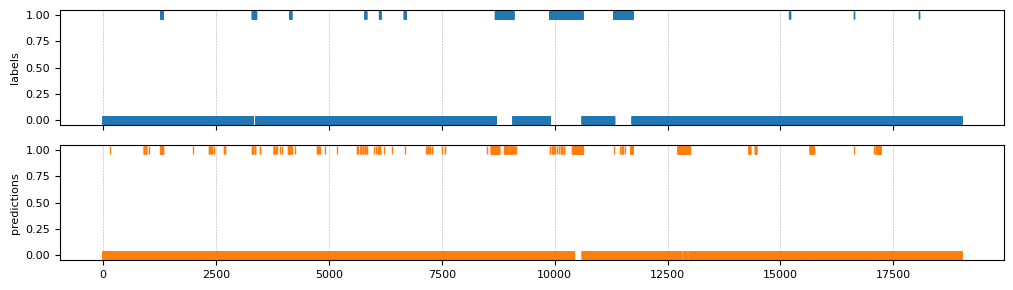

In [12]:
evaluate(model, X_test, y_test, "raw features")

That's pretty decent for a first try! Our model seems to be learning.

The plotted predictions seem to be all over the place though, with the model sporadically predicting anomaly events throughout in several non-anomalous periods.

There's plenty of room for improvement, so let's kick off the feature engineering!

## Feature engineering

### Lag features

Right now our model only has access to each event's raw metric values, + the group and machine that it belongs to. This means that it has no knowledge of the **context** an event is happening on - some values might have been completely normal when the measuring started, but anomalous a couple of weeks later, e.g. if that machine's usage went up as a whole during that time and its baseline usage now stands much higher than it used to.

To combat this, we'll start by lagging the values of each feature. In doing this, we're providing the model (some) information about that the metric's value looked like a couple of steps into the past.

In [13]:
lag_features = []

# Lag each raw feature by 1, 2, ..., 10 steps
for window in range(1, 11):
    lag_features.append(raw_features.lag(window).resample(raw_features).prefix(f"lag_{window}_"))

features = tp.glue(raw_features, *lag_features)
features

indexes: [('machine', str_)]
features: [('f0', float32), ('f1', float32), ('f2', float32), ('f3', float32), ('f4', float32), ('f5', float32), ('f6', float32), ('f7', float32), ('f8', float32), ('f9', float32), ('f10', float32), ('f11', float32), ('f12', float32), ('f13', float32), ('f14', float32), ('f15', float32), ('f16', float32), ('f17', float32), ('f18', float32), ('f19', float32), ('f20', float32), ('f21', float32), ('f22', float32), ('f23', float32), ('f24', float32), ('f25', float32), ('f26', float32), ('f27', float32), ('f28', float32), ('f29', float32), ('f30', float32), ('f31', float32), ('f32', float32), ('f33', float32), ('f34', float32), ('f35', float32), ('f36', float32), ('f37', float32), ('lag_1_f0', float32), ('lag_1_f1', float32), ('lag_1_f2', float32), ('lag_1_f3', float32), ('lag_1_f4', float32), ('lag_1_f5', float32), ('lag_1_f6', float32), ('lag_1_f7', float32), ('lag_1_f8', float32), ('lag_1_f9', float32), ('lag_1_f10', float32), ('lag_1_f11', float32), ('lag_1_f12', float32), ('lag_1_f13', float32), ('lag_1_f14', float32), ('lag_1_f15', float32), ('lag_1_f16', float32), ('lag_1_f17', float32), ('lag_1_f18', float32), ('lag_1_f19', float32), ('lag_1_f20', float32), ('lag_1_f21', float32), ('lag_1_f22', float32), ('lag_1_f23', float32), ('lag_1_f24', float32), ('lag_1_f25', float32), ('lag_1_f26', float32), ('lag_1_f27', float32), ('lag_1_f28', float32), ('lag_1_f29', float32), ('lag_1_f30', float32), ('lag_1_f31', float32), ('lag_1_f32', float32), ('lag_1_f33', float32), ('lag_1_f34', float32), ('lag_1_f35', float32), ('lag_1_f36', float32), ('lag_1_f37', float32), ('lag_2_f0', float32), ('lag_2_f1', float32), ('lag_2_f2', float32), ('lag_2_f3', float32), ('lag_2_f4', float32), ('lag_2_f5', float32), ('lag_2_f6', float32), ('lag_2_f7', float32), ('lag_2_f8', float32), ('lag_2_f9', float32), ('lag_2_f10', float32), ('lag_2_f11', float32), ('lag_2_f12', float32), ('lag_2_f13', float32), ('lag_2_f14', float32), ('lag_2_f15', float32), ('lag_2_f16', float32), ('lag_2_f17', float32), ('lag_2_f18', float32), ('lag_2_f19', float32), ('lag_2_f20', float32), ('lag_2_f21', float32), ('lag_2_f22', float32), ('lag_2_f23', float32), ('lag_2_f24', float32), ('lag_2_f25', float32), ('lag_2_f26', float32), ('lag_2_f27', float32), ('lag_2_f28', float32), ('lag_2_f29', float32), ('lag_2_f30', float32), ('lag_2_f31', float32), ('lag_2_f32', float32), ('lag_2_f33', float32), ('lag_2_f34', float32), ('lag_2_f35', float32), ('lag_2_f36', float32), ('lag_2_f37', float32), ('lag_3_f0', float32), ('lag_3_f1', float32), ('lag_3_f2', float32), ('lag_3_f3', float32), ('lag_3_f4', float32), ('lag_3_f5', float32), ('lag_3_f6', float32), ('lag_3_f7', float32), ('lag_3_f8', float32), ('lag_3_f9', float32), ('lag_3_f10', float32), ('lag_3_f11', float32), ('lag_3_f12', float32), ('lag_3_f13', float32), ('lag_3_f14', float32), ('lag_3_f15', float32), ('lag_3_f16', float32), ('lag_3_f17', float32), ('lag_3_f18', float32), ('lag_3_f19', float32), ('lag_3_f20', float32), ('lag_3_f21', float32), ('lag_3_f22', float32), ('lag_3_f23', float32), ('lag_3_f24', float32), ('lag_3_f25', float32), ('lag_3_f26', float32), ('lag_3_f27', float32), ('lag_3_f28', float32), ('lag_3_f29', float32), ('lag_3_f30', float32), ('lag_3_f31', float32), ('lag_3_f32', float32), ('lag_3_f33', float32), ('lag_3_f34', float32), ('lag_3_f35', float32), ('lag_3_f36', float32), ('lag_3_f37', float32), ('lag_4_f0', float32), ('lag_4_f1', float32), ('lag_4_f2', float32), ('lag_4_f3', float32), ('lag_4_f4', float32), ('lag_4_f5', float32), ('lag_4_f6', float32), ('lag_4_f7', float32), ('lag_4_f8', float32), ('lag_4_f9', float32), ('lag_4_f10', float32), ('lag_4_f11', float32), ('lag_4_f12', float32), ('lag_4_f13', float32), ('lag_4_f14', float32), ('lag_4_f15', float32), ('lag_4_f16', float32), ('lag_4_f17', float32), ('lag_4_f18', float32), ('lag_4_f19', float32), ('lag_4_f20', float32), ('lag_4_f21', float32), ('lag_4_f22', float32), ('lag_4_f23', float32), ('lag_4_f24', 

Let's take a look at any metric alongside its lagged values. We'll select a small time window, to be able to appreciate how the time series moves to the right as the number of lagged timesteps increases.

The number of plots (33) is larger than "options.max_num_plots=10". Only the first plots will be printed.


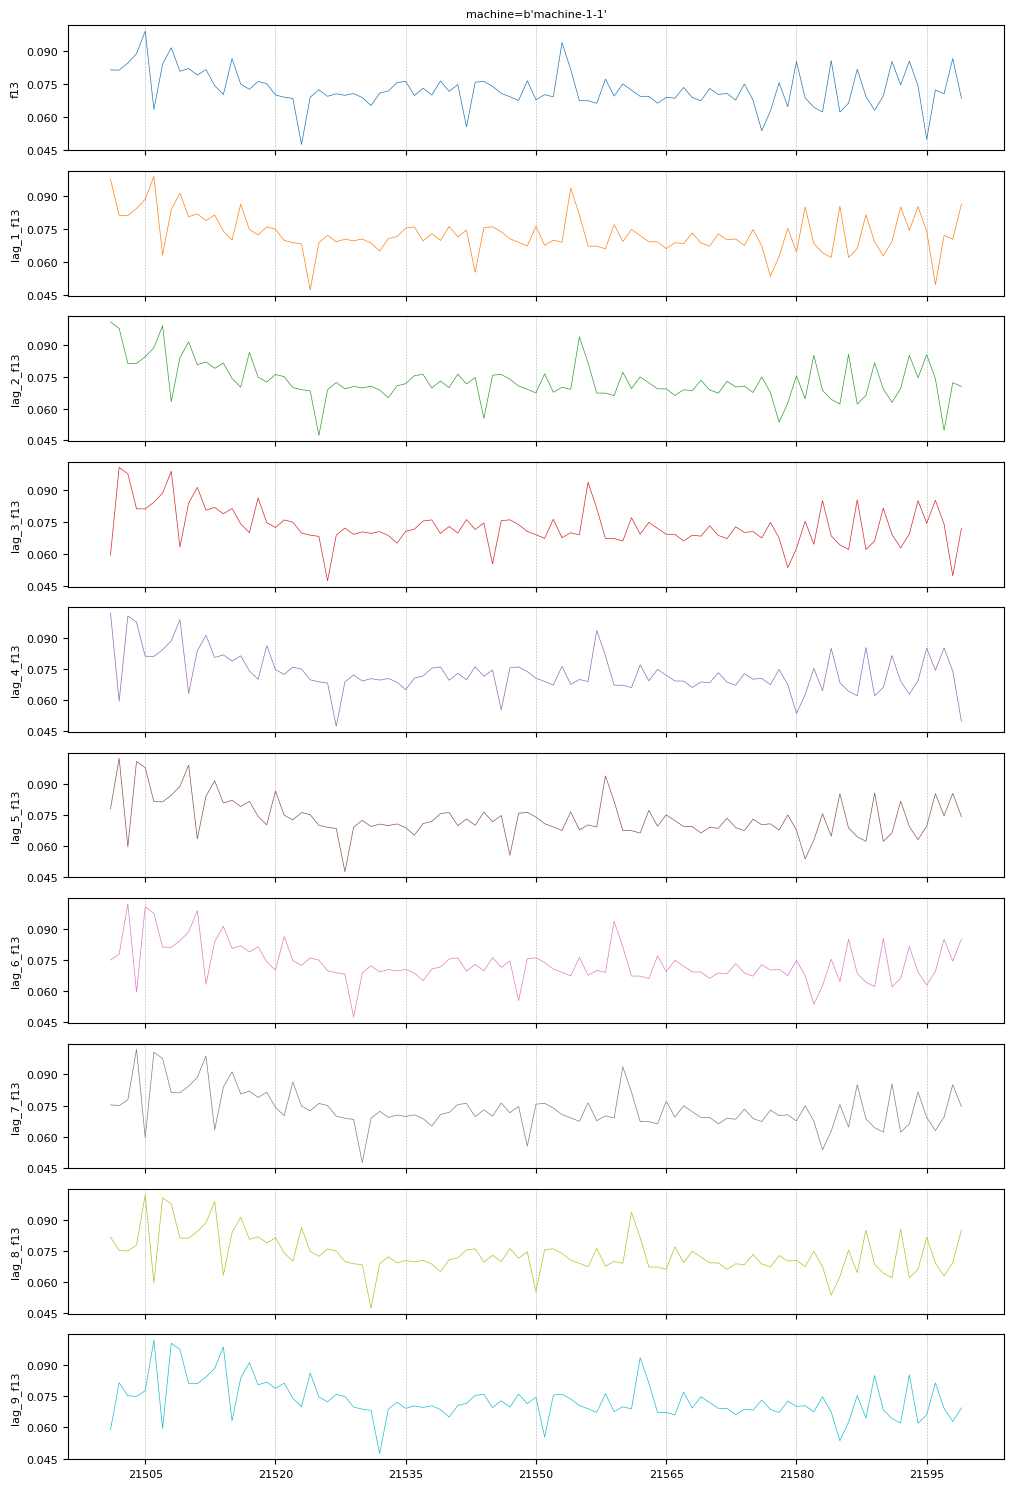

In [14]:
f13_lags = features[["f13"] + [f"lag_{i}_f13" for i in range(1, 11)]]
timestamps = f13_lags.timestamps()
f13_lags = f13_lags.filter((timestamps > 21500) & (timestamps < 21600))
f13_lags.plot(max_num_plots=10)

Time to train and evaluate a new model with these new features! 

Last train timestamp: 18955
Last train timestamp: 18955


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.3s finished


Results:
         raw features  lagged features
ROC AUC      0.879992          0.90135


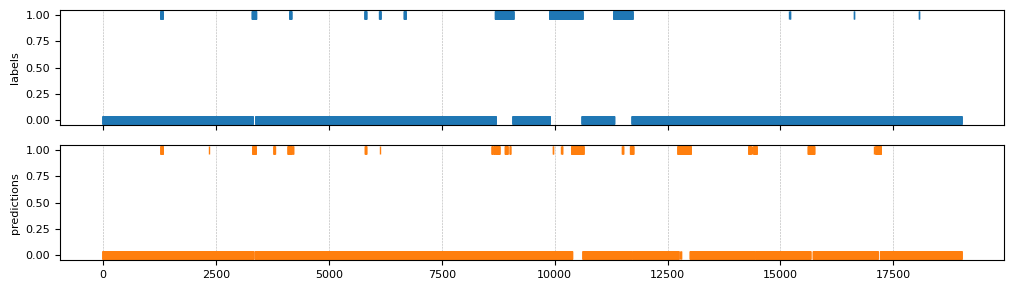

In [15]:
features_train, features_test = split_event_set(features)
_, labels_test = split_event_set(labels)

X_train, X_test, y_test = evsets_to_tabular(features_train, features_test, labels_test)

model = train(X_train)
evaluate(model, X_test, y_test, "lagged features")

Nice! The lagged features seem to have helped the model quite a bit. The ROC AUC went up, and the predictions are already looking more solid, with several anomalous periods being correctly identified.

### Moving statistic features

Although useful, the raw lagged values aren't enough to provide the model a comprehensive look at each value's past context. Note also that we only gave it a glimpse of 10 steps into the past, and each time series has more than 23k values.

This is where **moving statistics** can come in handy. Instead of a list of raw values, we can provide the model an aggregation of each metric's values over the last N timesteps. For example, we can tell it what the maximum and minimum value of a metric were in the last 20 steps, or what the standard deviation was in the last 1000. 

Luckily, Temporian's window operators make this a breeze.

In [16]:
moving_statistic_features = []

# Compute the moving average, standard deviation, max, and min over different windows
for window in [20, 200, 2000]:
    moving_statistic_features.append(raw_features.simple_moving_average(window).prefix(f"avg_{window}_"))
    moving_statistic_features.append(raw_features.moving_standard_deviation(window).prefix(f"std_{window}_"))
    moving_statistic_features.append(raw_features.moving_max(window).prefix(f"max_{window}_"))
    moving_statistic_features.append(raw_features.moving_min(window).prefix(f"min_{window}_"))

features = tp.glue(raw_features, *lag_features, *moving_statistic_features)
features

indexes: [('machine', str_)]
features: [('f0', float32), ('f1', float32), ('f2', float32), ('f3', float32), ('f4', float32), ('f5', float32), ('f6', float32), ('f7', float32), ('f8', float32), ('f9', float32), ('f10', float32), ('f11', float32), ('f12', float32), ('f13', float32), ('f14', float32), ('f15', float32), ('f16', float32), ('f17', float32), ('f18', float32), ('f19', float32), ('f20', float32), ('f21', float32), ('f22', float32), ('f23', float32), ('f24', float32), ('f25', float32), ('f26', float32), ('f27', float32), ('f28', float32), ('f29', float32), ('f30', float32), ('f31', float32), ('f32', float32), ('f33', float32), ('f34', float32), ('f35', float32), ('f36', float32), ('f37', float32), ('lag_1_f0', float32), ('lag_1_f1', float32), ('lag_1_f2', float32), ('lag_1_f3', float32), ('lag_1_f4', float32), ('lag_1_f5', float32), ('lag_1_f6', float32), ('lag_1_f7', float32), ('lag_1_f8', float32), ('lag_1_f9', float32), ('lag_1_f10', float32), ('lag_1_f11', float32), ('lag_1_f12', float32), ('lag_1_f13', float32), ('lag_1_f14', float32), ('lag_1_f15', float32), ('lag_1_f16', float32), ('lag_1_f17', float32), ('lag_1_f18', float32), ('lag_1_f19', float32), ('lag_1_f20', float32), ('lag_1_f21', float32), ('lag_1_f22', float32), ('lag_1_f23', float32), ('lag_1_f24', float32), ('lag_1_f25', float32), ('lag_1_f26', float32), ('lag_1_f27', float32), ('lag_1_f28', float32), ('lag_1_f29', float32), ('lag_1_f30', float32), ('lag_1_f31', float32), ('lag_1_f32', float32), ('lag_1_f33', float32), ('lag_1_f34', float32), ('lag_1_f35', float32), ('lag_1_f36', float32), ('lag_1_f37', float32), ('lag_2_f0', float32), ('lag_2_f1', float32), ('lag_2_f2', float32), ('lag_2_f3', float32), ('lag_2_f4', float32), ('lag_2_f5', float32), ('lag_2_f6', float32), ('lag_2_f7', float32), ('lag_2_f8', float32), ('lag_2_f9', float32), ('lag_2_f10', float32), ('lag_2_f11', float32), ('lag_2_f12', float32), ('lag_2_f13', float32), ('lag_2_f14', float32), ('lag_2_f15', float32), ('lag_2_f16', float32), ('lag_2_f17', float32), ('lag_2_f18', float32), ('lag_2_f19', float32), ('lag_2_f20', float32), ('lag_2_f21', float32), ('lag_2_f22', float32), ('lag_2_f23', float32), ('lag_2_f24', float32), ('lag_2_f25', float32), ('lag_2_f26', float32), ('lag_2_f27', float32), ('lag_2_f28', float32), ('lag_2_f29', float32), ('lag_2_f30', float32), ('lag_2_f31', float32), ('lag_2_f32', float32), ('lag_2_f33', float32), ('lag_2_f34', float32), ('lag_2_f35', float32), ('lag_2_f36', float32), ('lag_2_f37', float32), ('lag_3_f0', float32), ('lag_3_f1', float32), ('lag_3_f2', float32), ('lag_3_f3', float32), ('lag_3_f4', float32), ('lag_3_f5', float32), ('lag_3_f6', float32), ('lag_3_f7', float32), ('lag_3_f8', float32), ('lag_3_f9', float32), ('lag_3_f10', float32), ('lag_3_f11', float32), ('lag_3_f12', float32), ('lag_3_f13', float32), ('lag_3_f14', float32), ('lag_3_f15', float32), ('lag_3_f16', float32), ('lag_3_f17', float32), ('lag_3_f18', float32), ('lag_3_f19', float32), ('lag_3_f20', float32), ('lag_3_f21', float32), ('lag_3_f22', float32), ('lag_3_f23', float32), ('lag_3_f24', float32), ('lag_3_f25', float32), ('lag_3_f26', float32), ('lag_3_f27', float32), ('lag_3_f28', float32), ('lag_3_f29', float32), ('lag_3_f30', float32), ('lag_3_f31', float32), ('lag_3_f32', float32), ('lag_3_f33', float32), ('lag_3_f34', float32), ('lag_3_f35', float32), ('lag_3_f36', float32), ('lag_3_f37', float32), ('lag_4_f0', float32), ('lag_4_f1', float32), ('lag_4_f2', float32), ('lag_4_f3', float32), ('lag_4_f4', float32), ('lag_4_f5', float32), ('lag_4_f6', float32), ('lag_4_f7', float32), ('lag_4_f8', float32), ('lag_4_f9', float32), ('lag_4_f10', float32), ('lag_4_f11', float32), ('lag_4_f12', float32), ('lag_4_f13', float32), ('lag_4_f14', float32), ('lag_4_f15', float32), ('lag_4_f16', float32), ('lag_4_f17', float32), ('lag_4_f18', float32), ('lag_4_f19', float32), ('lag_4_f20', float32), ('lag_4_f21', float32), ('lag_4_f22', float32), ('lag_4_f23', float32), ('lag_4_f24', 

Taking a look at some of the generated features:

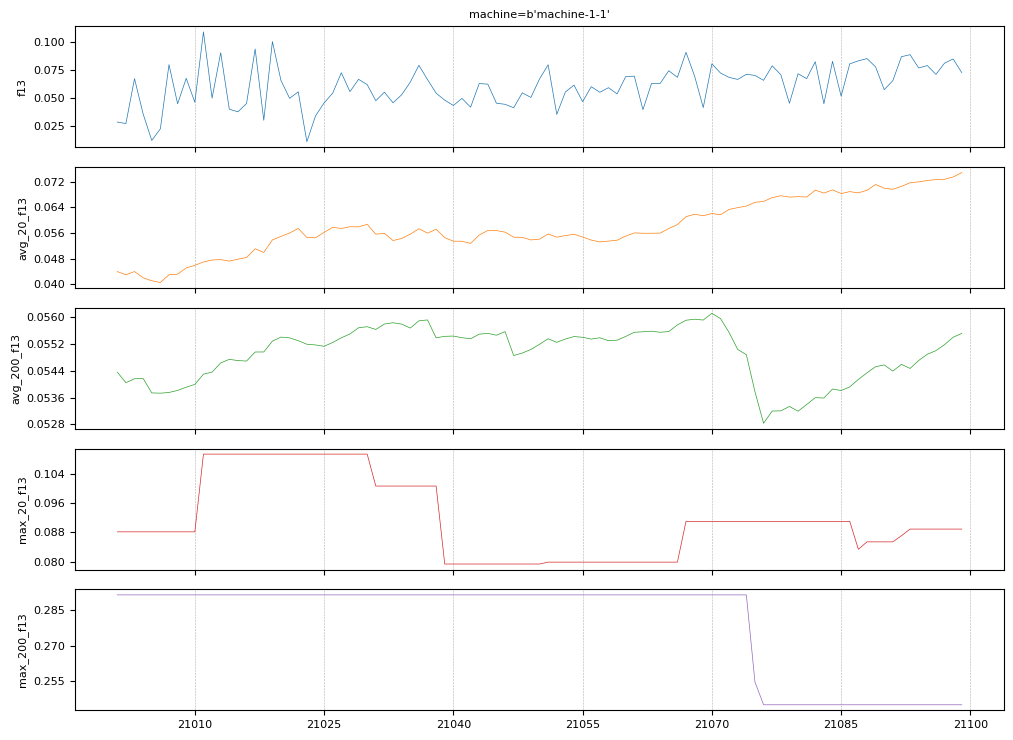

In [17]:
f13_stats = features[["f13", "avg_20_f13", "avg_200_f13", "max_20_f13", "max_200_f13"]]
timestamps = f13_stats.timestamps()
f13_stats = f13_stats.filter((timestamps > 21000) & (timestamps < 21100))
f13_stats.plot(indexes="machine-1-1")

Moving statistics can be a good indicator of what a sequence's "normal" behavior looks like. 

As an example, `"avg_20_f12"`'s plot shows how the average value of the series goes up with time - so it could allow the model to tell apart whether a value of `0.07` for `f13` is anomalous or not, depending on when it happens!

Last train timestamp: 18955
Last train timestamp: 18955


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.2s finished


Results:
         raw features  lagged features  moving statistics
ROC AUC      0.879992          0.90135           0.940627


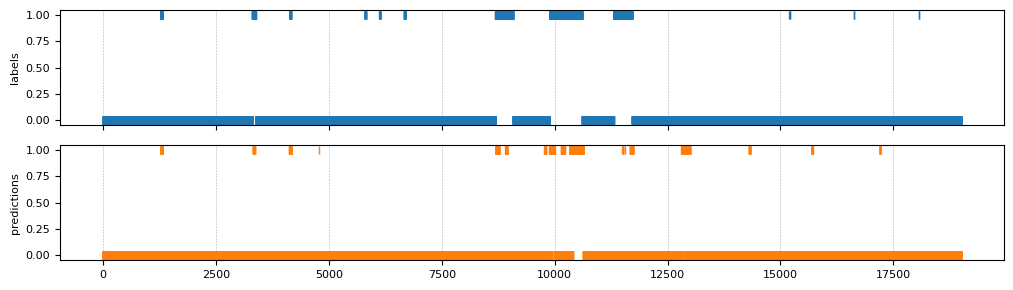

In [18]:
features_train, features_test = split_event_set(features)
_, labels_test = split_event_set(labels)

X_train, X_test, y_test = evsets_to_tabular(features_train, features_test, labels_test)

model = train(X_train)
evaluate(model, X_test, y_test, "moving statistics")

That's quite an improvement! Moving statistics can be of immense importance in an anomaly detection setting, since "anomalous" values tend to be defined as those that don't match the item's normal behavior, and moving statistics can help the model understand what "normal behavior" means for a a specific timeframe.

## Wrapping up

In this notebook we learned how to perform feature engineering and visualization using Temporian, applying it to a real-world anomaly detection use case.

There's some further work that could be done in this problem! Here's some ideas:
- Train a larger model! Training a larger model, on a larger dataset, would most likely yield improved results. As an example, try increasing the number of estimators in the IsolationForest (the default is 100), and optionally also increase the number of machines in each group to pull data from, and re-run the experiments!
- Use the dataset's [unlabeled train data](https://github.com/NetManAIOps/OmniAnomaly/tree/master/ServerMachineDataset/train) to train the model in this unsupervised manner, and then use the data we used here to test it only.
- Keep adding new features! As we demonstrated, a very simple model can go a long way if the correct features are provided to it. This is where Temporian shines - check out the full list of operators in the [API Reference](https://temporian.readthedocs.io/en/stable/reference/#operators) for some inspiration!